In [119]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import keras

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [121]:
print(os.getcwd())

/Users/wnowak/gitt/ffc/materialHardship


Set working directory to materialHardship folder.

In [122]:
os.chdir('/Users/wnowak/gitt/ffc/materialHardship/')

Import data needed for training and prediction.

In [123]:
# this is data the is SMOTED - synthetically oversampled from under reppresented classes and undersampled from over
# represented...it worked well to train on this in XGB, so we'll try again
final_over_balanced =  pd.read_pickle('Data/balanced/final_over_balanced_decimals')

In [168]:
final_over_balanced.shape

(6464, 11985)

In [124]:
df_prediction = pd.read_pickle('Data/df_prediction')

In [166]:
# medians is simply training data with median imputation
medians =  pd.read_pickle('Data/median_impute_df_train_with_labels')

In [167]:
medians.shape

(1459, 11985)

above, we see that medians and final_over_balanced have same number of features, but different number rows. 

## Split datasets into training and validation sets.

I split 2 separate sets...we want to have held-out / validation / test data that is "pure", so I DO NOT use the SMOTE adjusted data when performing validation. However, I do train with the balanced final_over_balanced set. 

In [171]:
# split data into features and labels
def split_data(df, label='materialHardship'):
    copy = df.copy() # copy df so i dont alter original df by popping
    mh = copy.pop(label) # pop label
    x_train_bal, x_valid_bal, y_train_bal, y_valid_bal = train_test_split(copy, mh, test_size=0.01) #train test split
    return x_train_bal, x_valid_bal, y_train_bal, y_valid_bal # return


# In[8]:

x_tr_bal, _, y_tr_bal, _ = split_data(final_over_balanced)

x_val, __, y_val, __ = split_data(medians)

In [127]:
# determine which columns to use when making prediction
df_prediction_good_cols = df_prediction[x_tr.columns.values] # keep the columns that are in training data...

But we have a potential problem...we can see below that there are NA's. And there are some columns in the prediction set (and not in the test set) that have all NA's, so we can't even do mean or median imputation for these. SOOOO...

In [128]:
df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0:10]

hv3pvnbasal    2783
hv4k4a         2782
hv3a16c3_0     2780
hv3a16d3_2     2779
hv3a16d3_8     2779
hv3a16d3_7     2779
hv3a16d3_6     2779
hv3a16d3_5     2779
hv3a16d3_4     2779
hv3a16d3_3     2779
dtype: int64

It is just hv3pvnbasal that has all rows missing ({{df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0]}} out of {{df_prediction_good_cols.shape[0]}}). So let's drop that from x_train. 

In [129]:
x_tr = x_tr.drop('hv3pvnbasal',1)
x_val = x_val.drop('hv3pvnbasal',1)
x_tr_bal = x_tr_bal.drop('hv3pvnbasal',1)

x_tr = x_tr.drop('challengeID',1)
x_val = x_val.drop('challengeID',1)
x_tr_bal = x_tr_bal.drop('challengeID',1)

## Prepare labels as one hots

In [175]:
y_tr_bal_ints = y_tr_bal*11

In [176]:
y_one_hot = pd.get_dummies(y_tr_bal_ints)

In [177]:
y_one_hot.shape

(6399, 10)

In [132]:
# X = x_tr.values # train on imbalanced
# X = x_tr_bal.values # train on augmented, balanced X
# Y = y_tr_bal.values
Y = y_one_hot.values

In [178]:
y_val_dums =  pd.get_dummies(y_val)

In [179]:
y_val_dums.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
1044,0,0,1,0,0,0,0,0,0,0
1316,1,0,0,0,0,0,0,0,0,0
423,0,1,0,0,0,0,0,0,0,0
573,1,0,0,0,0,0,0,0,0,0
1262,1,0,0,0,0,0,0,0,0,0


In [180]:
y_val_dums.shape

(1444, 10)

## Standardize inputs

In [140]:
import sklearn

In [181]:
# normed = pd.DataFrame(sklearn.preprocessing.normalize(x_tr))

In [182]:
normed_tr_vals = sklearn.preprocessing.normalize(x_tr_bal)
normed_val_vals = sklearn.preprocessing.normalize(x_val)

In [183]:
normed_tr_vals.shape

(6399, 11984)

## PCA on inputs

In [390]:
from sklearn.decomposition import PCA

In [391]:
pca = PCA(copy=True, n_components=2, whiten=False)

In [396]:
normed_val_vals.shape

(1444, 11984)

In [393]:
pca.fit(normed_tr_vals)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [394]:
# apply pca to train data
pca_tr = pca.transform(normed_tr_vals)
# apply pca to validation data
pca_val = pca.transform(normed_val_vals)

In [395]:
pca_val.shape

(6399, 2)

For kicks, let's visualize this PCA.

In [214]:
pca_train_df = pd.DataFrame(pca_tr)
pca_train_df.columns = ['dim1','dim2']
ys = y_tr_bal_ints.values
pca_train_df['label'] = ys

pca_train_df.head()


,dim1,dim2,label
0,0.541694,0.221838,2.0
1,0.424705,0.086797,3.0
2,0.109026,-0.397430,2.0
3,-0.129537,0.083650,3.0
4,-0.206232,-0.214636,1.0


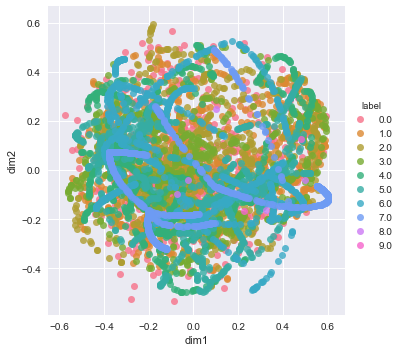

In [215]:
# tack back on labels
# plot in 2d and color by MH label
sns.lmplot('dim1', 'dim2', data=pca_train_df, hue='label', fit_reg=False)


Kinda cool...there are a lot of every class. Let's try the same thing on the not SMOTED data to see what we see.

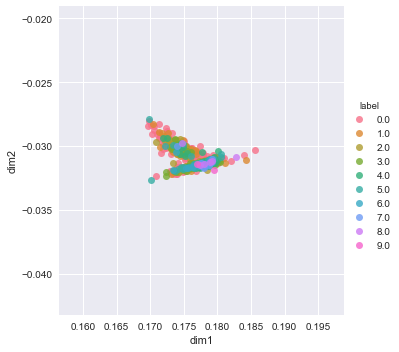

In [217]:
# tack back on labels
pca_val_df = pd.DataFrame(pca_val)
pca_val_df.columns = ['dim1','dim2']
ys = y_val.values
pca_val_df['label'] = ys
# plot in 2d and color by MH label
sns.lmplot('dim1', 'dim2', data=pca_val_df, hue='label', fit_reg=False)

There is a lot less variation above. This makes me think that maybe I did it backwards, in a way. Maybe we should have done PCA on the non-balanced set. Let's try that.

In [218]:
pcaa = PCA(copy=True, n_components=2, whiten=False)
pcaa.fit(normed_val_vals)

# apply pca to train data
pca_tr_orig = pcaa.transform(normed_tr_vals)
# apply pca to validation data
pca_val_orig = pcaa.transform(normed_val_vals)

(6399, 2)

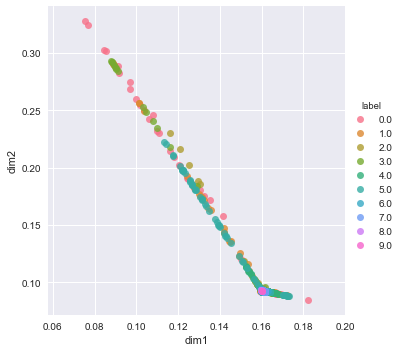

In [221]:
# tack back on labels
pca_tr_df_orig = pd.DataFrame(pca_tr_orig)
pca_tr_df_orig.columns = ['dim1','dim2']
ys_bal = y_tr_bal_ints.values
pca_tr_df_orig['label'] = ys_bal
# plot in 2d and color by MH label
sns.lmplot('dim1', 'dim2', data=pca_tr_df_orig, hue='label', fit_reg=False)
pca_tr_orig.shape

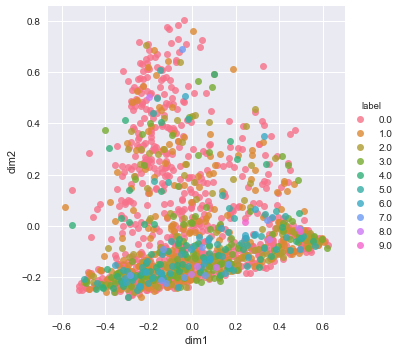

In [220]:
# tack back on labels
pca_val_df_orig = pd.DataFrame(pca_val_orig)
pca_val_df_orig.columns = ['dim1','dim2']
ys_val = y_val.values
pca_val_df_orig['label'] = ys_val
# plot in 2d and color by MH label
sns.lmplot('dim1', 'dim2', data=pca_val_df_orig, hue='label', fit_reg=False)


In [399]:
#make PCA graph function

def fit_PCA(data, num_components=2):
    '''
    give a np array of ( m x n ) dimensions
    reduce down to ( m x num_compnents ) dimensions
    '''
    pcaa = PCA(copy=True, n_components=num_components, whiten=False)
    return pcaa.fit(data)

def apply_PCA(model, new_data):
    '''
    given principles components of PCA fit (fit_PCA), return np array of num_components
    dimensions that represents projection of new_data onto that space
    '''
    return model.transform(new_data)

def graph_PCA(transformed_data,labels):
    '''
    create a dataframe of the transformed data and the corresponding class label
    make a scatterplot, coloring by class label
    '''
    # tack back on labels
    t_df = pd.DataFrame(transformed_data)
    t_df.columns = ['dim1','dim2']
    labs = labels.values
    t_df['label'] = labs
    # plot in 2d and color by MH label
    return sns.lmplot('dim1', 'dim2', data=t_df, hue='label', fit_reg=False)

# Make PCA plots

## PCA fit on non_balanced data, projected on non_balanced data

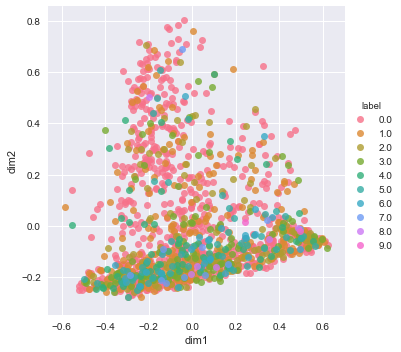

In [400]:
# make model
f = fit_PCA(normed_val_vals)
# apply PCA to data 
t = apply_PCA(f, normed_val_vals)
# graph with labels
graph_PCA(t,y_val)

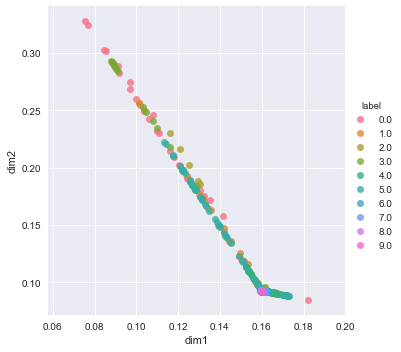

In [402]:
# apply PCA to data 
tr = apply_PCA(f, normed_tr_vals)
# graph with labels
graph_PCA(tr,y_tr_bal_ints)

# Remember...

I'll need to do PCA on final prediction set later.

# Train NN

In [153]:
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout

model = Sequential() # set up model

# add fully connected layer that go to num_nodes hidden nodes
num_nodes = 40
model.add(Dense(num_nodes, input_dim=pca_tr.shape[1], kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
# use linear combination of weights and values from previous layer to make one hot prediction
model.add(Dropout(0.9))
model.add(Dense(y_one_hot.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam')
# model.compile(loss='categorical_crossentropy',optimizer='adam')

# fit the model for num_epochs epochs. callbacks option can be set to activate early stopping
# include validation_data to measure both
calls = [EarlyStopping(monitor='val_loss',patience=5,verbose=0)]
num_epochs = 500
fitt = model.fit( pca_tr, Y, 
#                  batch_size=52,
                 epochs=num_epochs, 
                 verbose=1, 
                 callbacks=calls,
                 validation_split=0.1, 
                 validation_data=(pca_val_,y_val_OH))

Train on 1313 samples, validate on 146 samples
Epoch 1/500
1313/1313 [==============================] - 0s - loss: 0.6838 - val_loss: 0.6689
Epoch 2/500
1313/1313 [==============================] - 0s - loss: 0.6606 - val_loss: 0.6355
Epoch 3/500
1313/1313 [==============================] - 0s - loss: 0.6323 - val_loss: 0.5936

Make sure we use predictoin data frame that has same columns as training, and has no NAs...

In [154]:
df_prediction_good_cols = df_prediction[x_tr.columns.values] # keep the columns that are in training data...

In [155]:
df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0:10]

hv4k4a        2782
hv3a16c3_0    2780
hv3a16d3_5    2779
hv3a16d3_1    2779
hv3a16d3_2    2779
hv3a16d3_3    2779
hv3a16d3_4    2779
hv3a16d3_6    2779
hv3a16d3_7    2779
hv3a16d3_8    2779
dtype: int64

In [156]:
from fancyimpute import SimpleFill
filled = SimpleFill('median').complete(df_prediction_good_cols)

In [157]:
pd.DataFrame(filled).isnull().sum().sort_values(ascending=False)[0:10]

11981    0
3990     0
3999     0
3998     0
3997     0
3996     0
3995     0
3994     0
3993     0
3992     0
dtype: int64

In [158]:
# use trained model to predict
pcaa_pred = PCA(copy=True, n_components=200, whiten=False)
pcaa_pred.fit(filled)
pca_pred = pcaa.transform(filled)

In [159]:
preds_train  = model.predict(pca_tr,verbose=1)

  32/1313 [..............................] - ETA: 9s

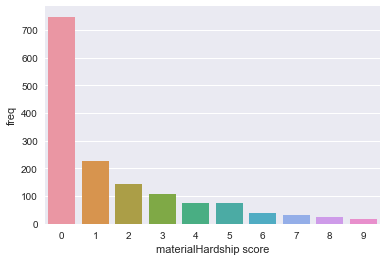

In [160]:
preds_train
pred__train_df  = pd.DataFrame(preds_train)
pred__train_df.head()
pred_sums_tr = pd.DataFrame(pred__train_df.sum(axis=0)).reset_index()
pred_sums_tr.columns = ['score','obs']
pred_sums_tr.head()
# check out distribution of predictions...
ax = sns.barplot(x="score", y="obs", data=pred_sums_tr)
plt.ylabel('freq')
plt.xlabel('materialHardship score')
plt.show()

In [161]:
preds  = model.predict(pca_pred,verbose=1)

2208/2783 [======================>.......] - ETA: 0s

In [162]:
preds

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [163]:
pred_df  = pd.DataFrame(preds)
pred_df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
pred_sums = pd.DataFrame(pred_df.sum(axis=0)).reset_index()
pred_sums.columns = ['score','obs']
pred_sums.head()

,score,obs
0,0,1919.990234
1,1,727.596375
2,2,11.207695
3,3,27.058479
4,4,20.020681


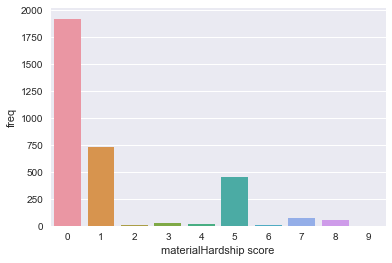

In [165]:
# check out distribution of predictions...
ax = sns.barplot(x="score", y="obs", data=pred_sums)
plt.ylabel('freq')
plt.xlabel('materialHardship score')
plt.show()

Below, I plot train and validation losses.

In [49]:
# fitt has history
hist_df = pd.DataFrame(fitt.history)
hist_df.head()

,loss,val_loss
0,11.269165,10.996299
1,11.011381,8.831833
2,10.360756,8.390241
3,9.918829,7.727854
4,8.262158,6.623875


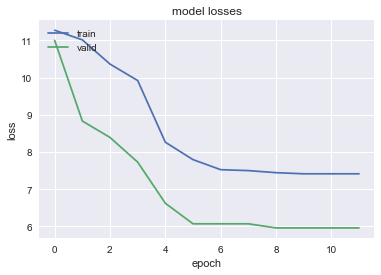

In [50]:
# summarize history for accuracy
plt.plot(fitt.history['loss'])
plt.plot(fitt.history['val_loss'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# plt.set_ylim([0,100000])

# ax1 = plt.subplot(131)
# ax1.scatter([1, 2], [3, 4])
# ax1.set_xlim([0, 5])
# ax1.set_ylim([0, 5])